This notebook has been used to complete all the task asked to do. 

Starting with importing necessary libraries.

In [53]:
import numpy as np
from numpy import expand_dims

from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from matplotlib import pyplot
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

from os import listdir
from os.path import isdir
import os
import shutil

from PIL import Image
import matplotlib.pyplot as plt
from numpy import savez_compressed
from numpy import asarray
#from mtcnn.mtcnn import MTCNN
import numpy as np
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
#from keras.models import load_model

from numpy import load

import pandas as pd

In [30]:
# Loading model that we will be using
# for detecting humans
model = load_model('model.h5')

# Approach for Problem:
1. I snipped above 1000 pixels from image, we can observe by magnifying the image that there are not person in top 1000 pixels hence they are junk.
2. After that I divided image in 4 equal quarters, this makes the task of model to find humans significantly easy.
3. To prove point `2` at the last of this notebook I have predicted human in an snipped image which gives probability of detecting human to be **94%** whereas in normal situtation this probabilties turns out to be just 33% for the same person.
4. To predict average IOU I calulated iou for each predicted box with every real boxes and took maximum fom all those. As it can be expected that persons predicted box will give greated iou value with its real box only. 
5. In final results predicted boxes has been shown in red boxes and real boxes has been shown in blue color. Also predicted boxes has been labelled with confidence of the probabilty with which they have predicted the image to be particular image. 

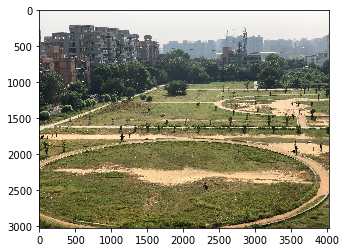

In [31]:
#Loading original image
image = Image.open('hd.jpg')
# Converting Image into array
image = asarray(image)
# Finding dimensions of image
heigth, width, channel= np.shape(image)
plt.imshow(image)

This is how image looks like after removing top 1000 pixels 

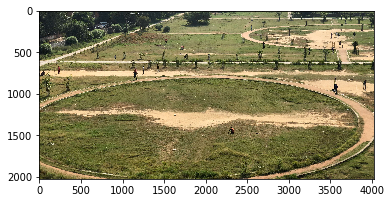

In [32]:
# ignoring top 1000 pixels
plt.imshow(image[1000:,:])

In [13]:
junk_heigth = 1000

From here onwards we will created for equal parts of remaining images and save it in the directory.

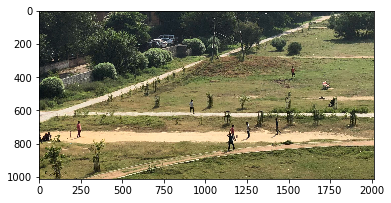

In [18]:
plt.imshow(image[junk_heigth:junk_heigth+(heigth-junk_heigth)//2,:(width//2)])
plt.savefig('hd1.jpg',dpi=1000)

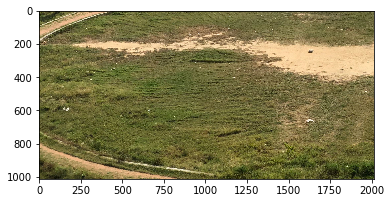

In [21]:
plt.imshow(image[junk_heigth+(heigth-junk_heigth)//2:,:(width//2)])
plt.savefig('hd2.jpg',dpi=1000)

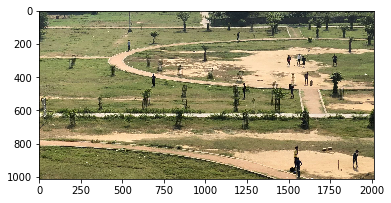

In [23]:
plt.imshow(image[junk_heigth:junk_heigth+(heigth-junk_heigth)//2,(width//2):])
plt.savefig('hd3.jpg',dpi=1000)

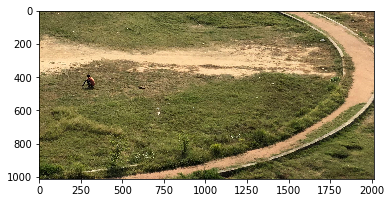

In [24]:
plt.imshow(image[junk_heigth+(heigth-junk_heigth)//2:,(width//2):])
plt.savefig('hd4.jpg',dpi=1000)

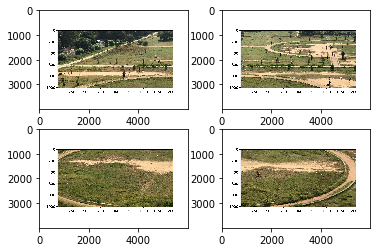

In [27]:
# Showing all the quarters in one image
im1 = Image.open('hd1.jpg')
im1 = asarray(im1)
im2 = Image.open('hd2.jpg')
im2 = asarray(im2)
im3 = Image.open('hd3.jpg')
im3 = asarray(im3)
im4 = Image.open('hd4.jpg')
im4 = asarray(im4)

plt.subplot(2,2,1)
plt.imshow(im1)
plt.subplot(2,2,2)
plt.imshow(im3)
plt.subplot(2,2,3)
plt.imshow(im2)
plt.subplot(2,2,4)
plt.imshow(im4)
plt.show()

In next cell I have used functions from https://github.com/experiencor/keras-yolo3. Utility of these functions will be explained while using these functions.

In [99]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0 
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In the cell below code is written to calulate iou for two boxes. This function has been taken from the link https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [81]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [88]:
# Starting points for differnet files used
# for different quarters
files = ['hd1','hd2','hd3','hd4']

Average IOU for current quarter of image:  0.1799705187006876


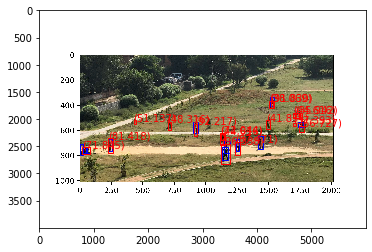

Average IOU for current quarter of image:  0


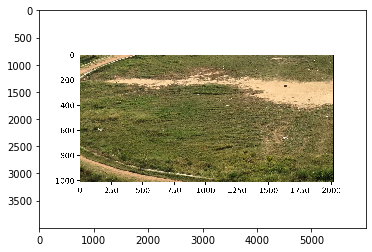

Average IOU for current quarter of image:  0.3838506758569477


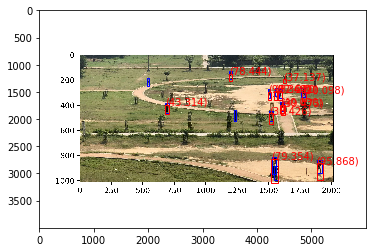

Average IOU for current quarter of image:  0.4923673997412678


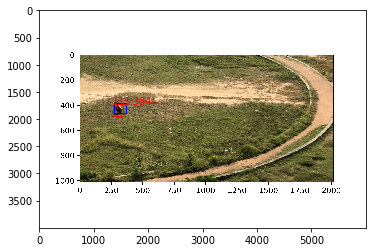

Total Number of persons are:  33
Overall Average of IOU is: 0.2635753298193452


In [97]:
total_person = 0
iou_avg = 0

# I will iterate over different
# quarters of images
for file in files:
    # Getting file name for current quarter of image
    img_file = file+'.jpg'
    # Getting file name for the image I am going to save in future
    save_img_file = file + '_box.jpg'
    csv_file = file + '_rb.csv'

    # Loading quarter of image
    image = load_img(img_file)
    # Getting dimension of images
    heigth, width = image.size
    #Resizing image
    image = load_img(img_file, target_size = (416,416))
    #Converting image into array format
    image = img_to_array(image)
    image = image.astype('float32')
    
    # Normalizing pixels of image
    image /= 255.0
    # Expanding dimension of image ot make it compatible to feed in the model 
    image = expand_dims(image, 0)

    # predicting the output of model
    pred = model.predict(image)
    
    
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

    # Bounding Box which does not have confidence pf predicting the object
    # above 33% will be ignored
    threshold = 0.33

    # Boxes xmin, ymin, xmax, ymax will be stored in this list
    boxes = []

    # Output of model need to be decoded.. 
    # experiencor provides a function decode_netout to decode the output
    # to get boxes and their labels
    for i in range(len(pred)):
        boxes += decode_netout(pred[i][0], anchors[i], threshold, 416, 416)

    # Real Boxes xmin, ymin, xmax, ymax will be stored in this list
    real_boxes = []

    # Real boxes xmin, ymin , xmax, ymax has been stored in csv format,
    # which needs to be read using pandas
    array = pd.read_csv(csv_file)
    # Converting pandas datframe into numpy 
    array = array.values
    
    # iterating over array to fill up real_boxes with 'BOundBox' objects
    for box in array:
        box = BoundBox(box[0], box[1], box[2], box[3])
        real_boxes.append(box)


    # experiencor  provides correct_yolo_boxes to resize the boxes for
    # original images
    correct_yolo_boxes(boxes, width, heigth, 416, 416)

    do_nms(boxes, 0.5)

    # defining labels the model can predict
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
        "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
        "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
        "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
        "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
        "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
        "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
        "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
        "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
        "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


    # now in box_dim we will store dimesnions of boxes
    box_dim = []
    # box_lable will store label boxes in parallel
    box_label = []
    #box_prob will give confidence with which the object has been predicted
    box_prob = []

    for box in boxes:
        for i in range(len(labels)):
            # If confidence of precition is less then threshold then that box
            # will be ignored
            if box.classes[i] > threshold:
                box_dim.append(box)
                box_label.append(labels[i])
                box_prob.append(box.classes[i]*100)

    # box_iou will store iou value for each preicted boxes
    box_iou = []
    for box in box_dim:
        possible_ious = []
        # We will calculate iou of predicted with every real box
        for real_box in real_boxes:
            boxA = [box.xmin, box.ymin, box.xmax, box.ymax]
            boxB = [real_box.xmin, real_box.ymin, real_box.xmax, real_box.ymax]
            possible_ious.append(bb_intersection_over_union(boxA, boxB))
        # Maximum of all ious will be assigned to a given box
        box_iou.append(max(possible_ious))
    if len(box_iou) == 0:
        iou = 0
    else:
        iou = np.mean(box_iou)
    # Average of IOU is printed for given quarter 
    print('Average IOU for current quarter of image: ',iou)

    
    # Proceeding for SHowing image with boxes
    image = Image.open(img_file)
    image = asarray(image)
    plt.imshow(image)

    ax = pyplot.gca()

    # Real boxes will be predicted with blue color
    for i in range(len(real_boxes)):
        box = real_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, heigth = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, heigth, fill=False, color='blue')
        ax.add_patch(rect)
        
    # Predicted boxes will be predicted with red color and probability labelled with it
    for i in range(len(box_dim)):
        box = box_dim[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, heigth = x2 - x1, y2 - y1
        if box_label[i] == 'person':
            rect = Rectangle((x1, y1), width, heigth, fill=False, color='red')
            ax.add_patch(rect)
            label = "(%.3f)" % (box_prob[i])
            pyplot.text(x1, y1, label, color='red')

    # Saving Image
    plt.savefig(save_img_file,dpi=2000)
    plt.show()
    
    total_person += len(box_dim)
    iou_avg += len(box_dim)*iou
# Now printing Total Number of People in the image
# actually given, with average iou for given image
print ('Total Number of persons are: ', total_person)
print ('Overall Average of IOU is:', iou_avg/total_person)

C:\Users\HP\Anaconda3\envs\intuitive-deep-learning\lib\site-packages\PIL\Image.py:2835: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


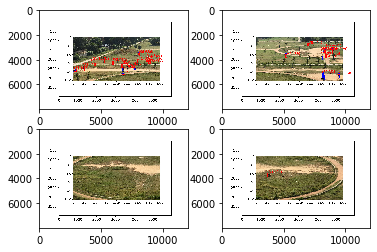

In [98]:
im1 = Image.open('hd1_box.jpg')
im1 = asarray(im1)
im2 = Image.open('hd2_box.jpg')
im2 = asarray(im2)
im3 = Image.open('hd3_box.jpg')
im3 = asarray(im3)
im4 = Image.open('hd4_box.jpg')
im4 = asarray(im4)

plt.subplot(2,2,1)
plt.imshow(im1)
plt.subplot(2,2,2)
plt.imshow(im3)
plt.subplot(2,2,3)
plt.imshow(im2)
plt.subplot(2,2,4)
plt.imshow(im4)
plt.show()

As was mentioned before, here onwards it has been shown that by snipping and searching over small area imporves the result.

 it can been observed that confidence level for this to be human is 93% but before it was just 33%

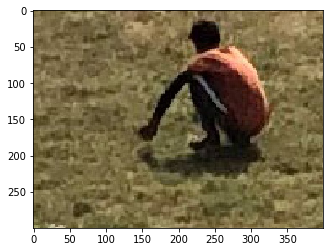

In [42]:
image = Image.open('hd4.jpg')
image = asarray(image)
plt.imshow(image[1700:2000,1200:1600])
plt.savefig('hd_.jpg',dpi=1000)

Total Number of persons are:  1


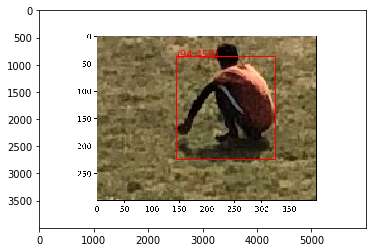

In [43]:
file = 'hd_'
img_file = file+'.jpg'
save_img_file = file + '_box.jpg'
image = load_img(img_file)
heigth, width = image.size
image = load_img(img_file, target_size = (416,416))
image = img_to_array(image)
image = image.astype('float32')
image /= 255.0
image = expand_dims(image, 0)

pred = model.predict(image)
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

threshold = 0.3

boxes = []

for i in range(len(pred)):
    boxes += decode_netout(pred[i][0], anchors[i], threshold, 416, 416)
    
correct_yolo_boxes(boxes, width, heigth, 416, 416)

do_nms(boxes, 0.5)

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


box_dim = []
box_label = []
box_prob = []

for box in boxes:
    for i in range(len(labels)):
        if box.classes[i] > threshold:
            box_dim.append(box)
            box_label.append(labels[i])
            box_prob.append(box.classes[i]*100)

print ('Total Number of persons are: ', len(box_dim))
            
image = Image.open(img_file)
image = asarray(image)
plt.imshow(image)

ax = pyplot.gca()
for i in range(len(box_dim)):
    box = box_dim[i]
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    width, heigth = x2 - x1, y2 - y1
    if box_label[i] == 'person':
        rect = Rectangle((x1, y1), width, heigth, fill=False, color='red')
        ax.add_patch(rect)
        label = "(%.3f)" % (box_prob[i])
        pyplot.text(x1, y1, label, color='red')

plt.savefig(save_img_file,dpi=2000)
plt.show()
